In [3]:
!export JAX_PLATFORMS=cpu
import tszpower
from classy_sz import Class as Class_sz
import jax
import jax.numpy as jnp 
import numpy as np
import torch
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi.analysis import pairplot
from sbi.inference import NPE
from sbi.inference import NLE
# from sbi.inference import FMPE
import matplotlib.pyplot as plt

2025-02-18 11:01:15.579024: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739876476.001881 2307245 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739876476.086232 2307245 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1739876484.737762 2307245 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/data/vault/lx256/envs/sz_clusters/lib64/python3.9/site-packages/jax/_

In [4]:
# 1) Define parameters
allpars = {
    # 'output': '',
    'omega_b': 0.0225,
    'omega_cdm': 0.12,
    'H0': 87.66,
    'tau_reio': 0.0561,
    'ln10^{10}A_s': 3.0,
    'n_s': 0.9665,
    'M_min': 1e10,
    'M_max': 3.5e15,
    # 'ell_min': 2,
    # 'ell_max': 8000,
    # 'dlogell': 0.1,
    'z_min': 5e-3,
    'z_max': 3.0,
    'P0GNFW': 8.130,
    'c500': 1.156,
    'gammaGNFW': 0.3292,
    'alphaGNFW': 1.0620,
    'betaGNFW': 5.4807,
    'B': 1.0,
    # "cosmo_model": 1, # use mnu-lcdm emulators
    'jax': 1
}

In [5]:
tszpower.classy_sz.set(allpars)
tszpower.classy_sz.compute_class_szfast()
# relavant_pars = tszpower.classy_sz.get_all_relevant_params(allpars)

In [6]:
# compute_Cl_yy_total(logA, omega_b, omega_cdm, H0, n_s, B, A_cib, A_rs, A_ir, key, params_values_dict=None, n_realizations=1)
logA = [3., 3.2]
omega_b = [0.0225, 0.0235]
omega_cdm = [0.12, 0.13]
H0 = [69., 71.]
n_s = [0.965, 0.967]
B = [1.6, 2.0]
A_cib =[0.5, 1.5]
A_rs = [1.5, 2.5]
A_ir = [1.5, 2.5]

(2, 18)
(2, 18)


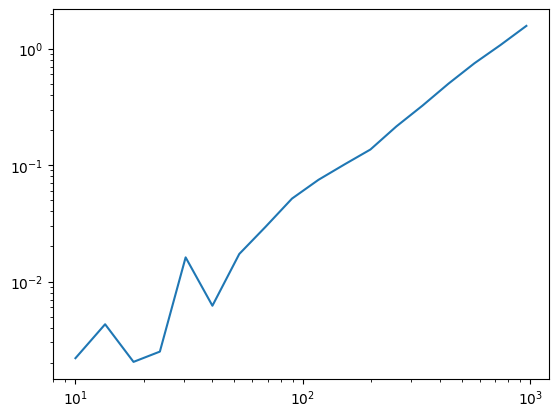

In [7]:
key = jax.random.PRNGKey(66)
print(tszpower.compute_Cl_yy_noiseless(logA, omega_b, omega_cdm, H0, n_s, B, params_values_dict=allpars).shape)
print(tszpower.compute_foreground(A_cib, A_rs, A_ir).shape)
Dl_yy = tszpower.compute_Cl_yy_total(logA, omega_b, omega_cdm, H0, n_s, B, A_cib, A_rs, A_ir, key, params_values_dict=allpars)
ell = tszpower.get_ell_range()
plt.loglog(ell, Dl_yy[0])

In [8]:
def simulator(theta: torch.Tensor) -> torch.Tensor:
    """
    Simulator that wraps tszpower.compute_Cl_yy_total.
    
    The input `theta` is expected to be a torch.Tensor of shape (batch, 9)
    with columns ordered as:
      [logA, omega_b, omega_cdm, H0, n_s, B, A_cib, A_rs, A_ir]
      
    This function uses the torch tensor directly by converting each element
    to a Python float, calls the tszpower simulator, and then returns a torch.Tensor.
    """
    batch_size = theta.shape[0]
    
    # Generate a base key and split it for each simulation.
    base_key = jax.random.PRNGKey(42)
    keys = jax.random.split(base_key, batch_size)
    # print(keys)
    
    sim_list = []
    for i in range(batch_size):
        # Extract each parameter as a Python float
        logA      = float(theta[i, 0])
        omega_b   = float(theta[i, 1])
        omega_cdm = float(theta[i, 2])
        H0        = float(theta[i, 3])
        n_s       = float(theta[i, 4])
        B         = float(theta[i, 5])
        A_cib     = float(theta[i, 6])
        A_rs      = float(theta[i, 7])
        A_ir      = float(theta[i, 8])
        
        # Call your tszpower simulator (which uses JAX internally)
        sim_i = tszpower.compute_Cl_yy_total(
            logA,
            omega_b,
            omega_cdm,
            H0,
            n_s,
            B,
            A_cib,
            A_rs,
            A_ir,
            keys[i],
            params_values_dict=allpars,  # your global parameter dictionary
            n_realizations=1
        )
        # Convert the returned JAX array to a NumPy array and then to a torch.Tensor
        sim_torch = torch.tensor(np.array(sim_i), dtype=torch.float32)
        sim_list.append(sim_torch)
    
    # Stack the results to form a tensor of shape (batch, n_ell)
    return torch.stack(sim_list, dim=0)


In [9]:
# --- Define the Prior ---
# We need a 9-dimensional prior (one for each free parameter).
# Order: [logA, omega_b, omega_cdm, H0, n_s, B, A_cib, A_rs, A_ir]

low = torch.tensor([2.5,   0.02,  0.11, 55.,  0.94, 1.0, 0.0, 0.0, 0.0])
high = torch.tensor([3.5, 0.025, 0.13, 90.,  1.0,  2.0, 5.0, 5.0, 5.0])
prior = BoxUniform(low=low, high=high)

# Process the prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)
# Process the simulator to ensure it returns batched outputs and torch.Tensors.
simulator = process_simulator(simulator, prior, prior_returns_numpy)
# Check consistency.
check_sbi_inputs(simulator, prior)

In [10]:
# inference = NPE(prior=prior)
inference = NLE(prior)
proposal = prior

In [11]:
data_file = np.loadtxt("data/data_ps-ell-y2-erry2_total-planck-collab-15.txt")
x_o = data_file[:, 1]
# x_o

In [12]:
num_rounds = 10
num_sims = 1000

for round_idx in range(1, num_rounds + 1):
    print(f"Round {round_idx}")
    
    # Sample simulations
    theta = proposal.sample((num_sims,))
    x = simulator(theta)
    
    # Save the simulated data into separate files per round
    torch.save(theta, f"theta_round{round_idx}_1k.pt")
    torch.save(x, f"x_round{round_idx}_1k.pt")
    print(f"Saved theta_round{round_idx}.pt and x_round{round_idx}.pt")

Round 1
Saved theta_round1.pt and x_round1.pt
Round 2
Saved theta_round2.pt and x_round2.pt
Round 3
Saved theta_round3.pt and x_round3.pt
Round 4
Saved theta_round4.pt and x_round4.pt
Round 5
Saved theta_round5.pt and x_round5.pt
Round 6
Saved theta_round6.pt and x_round6.pt
Round 7
Saved theta_round7.pt and x_round7.pt
Round 8
Saved theta_round8.pt and x_round8.pt
Round 9
Saved theta_round9.pt and x_round9.pt
Round 10
Saved theta_round10.pt and x_round10.pt


In [13]:
# num_rounds = 5
# num_sims = 1000
# for _ in range(num_rounds):
#     theta = proposal.sample((num_sims,))
#     x = simulator(theta)
#     _ = inference.append_simulations(theta, x).train()
#     posterior = inference.build_posterior(mcmc_method="slice_np_vectorized",
#                                           mcmc_parameters={"num_chains": 20,
#                                                            "thin": 5})
#     proposal = posterior.set_default_x(x_o)

In [14]:
# # --- Generate Simulations ---
# num_simulations = 1000
# theta = prior.sample((num_simulations,))  # shape (2000, 9)
# x = simulator(theta)           # x should have shape (2000, n_ell)
# # print("theta.shape", theta.shape)
# # print("x.shape", x.shape)
# inference.append_simulations(theta, x).train()


In [15]:
# posterior = inference.build_posterior()
# # posterior = inference.build_posterior().set_default_x(x_o)
# print(posterior) # prints how the posterior was trained

In [16]:
samples = posterior.sample((10000,), x=x_o)
print(samples)

NameError: name 'posterior' is not defined

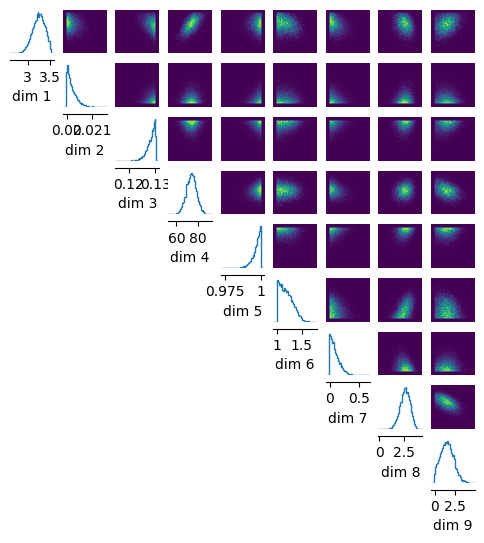

In [ ]:
_ = pairplot(samples,
             # limits=[[-2, 2], [-2, 2], [-2, 2]],
             figsize=(6, 6),)
             # labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"])

In [ ]:
# print(samples)
# Assuming samples is your tensor
np.savetxt('samples_NLE.txt', samples.numpy())